In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Proprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# XGBoost Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from sklearn.linear_model import Ridge

# For reproducibility
from teachopencadd.utils import seed_everything
SEED = 42
seed_everything(SEED)

In [2]:
train_file_path_UMAP = '../Data/Data/train_filter_UMAP.csv'
train_df_UMAP = pd.read_csv(train_file_path_UMAP)

In [3]:
ode_cols = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
ohe_cols = ['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']
num_cols = train_df_UMAP.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop("SalePrice")

In [4]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

])

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough',
    n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [5]:
X = train_df_UMAP.drop('SalePrice', axis=1)
Y = train_df_UMAP['SalePrice']

# Pass the data through the pipeline
X_preprocessed = pipeline.fit_transform(X)

# Train test split
x_train_UMAP, x_test_UMAP, y_train_UMAP, y_test_UMAP= train_test_split(X_preprocessed, Y, test_size=0.2, random_state=SEED)

# Ridge

In [6]:
def objective_UMAP_Ridge(trial):

    alpha = trial.suggest_categorical('alpha', [0.05, 0.1, 0.2, 0.5, 1, 2, 3,5, 10])
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'])
    model = Ridge(alpha=alpha, solver=solver, random_state=SEED)
    model.fit(x_train_UMAP, y_train_UMAP)

    score = cross_val_score(model, x_train_UMAP, y_train_UMAP, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score



In [7]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train_UMAP, y_train_UMAP)
y_pred = ridge.predict(x_test_UMAP)


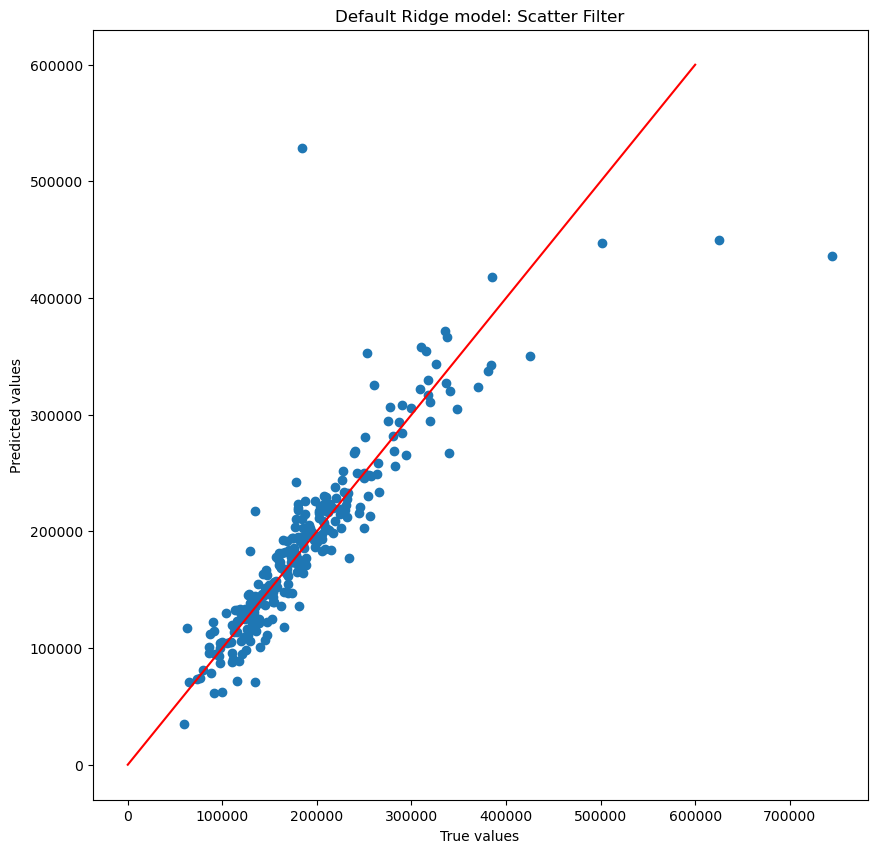

R^2: 0.787
RMSE: 37377.130
MAE: 19348.438
Pearson correlation: 0.888
Spearman correlation: 0.943


In [8]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_UMAP, y_pred)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Default Ridge model: Scatter Filter")
plt.show()

pearson_corr, _ = stats.pearsonr(y_test_UMAP, y_pred)
spearman_corr, _ = stats.spearmanr(y_test_UMAP, y_pred)
r2 = r2_score(y_test_UMAP, y_pred)
mae = mean_absolute_error(y_test_UMAP, y_pred)
rmse = math.sqrt(mean_squared_error(y_test_UMAP, y_pred))

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

In [9]:
study_UMAP_ridge = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=SEED))
study_UMAP_ridge.optimize(objective_UMAP_Ridge, n_trials=1000, show_progress_bar=True)

[I 2024-08-26 15:58:04,777] A new study created in memory with name: no-name-9c52d432-38e3-48e5-a594-b06926d50761


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-08-26 15:58:07,762] Trial 0 finished with value: -1307821952.345594 and parameters: {'alpha': 0.1, 'solver': 'cholesky'}. Best is trial 0 with value: -1307821952.345594.
[I 2024-08-26 15:58:09,979] Trial 1 finished with value: -1301839052.262841 and parameters: {'alpha': 2, 'solver': 'svd'}. Best is trial 1 with value: -1301839052.262841.
[I 2024-08-26 15:58:10,229] Trial 2 finished with value: -1308160634.2239666 and parameters: {'alpha': 1, 'solver': 'sparse_cg'}. Best is trial 1 with value: -1301839052.262841.
[I 2024-08-26 15:58:10,561] Trial 3 finished with value: -1301839052.262841 and parameters: {'alpha': 2, 'solver': 'svd'}. Best is trial 1 with value: -1301839052.262841.
[I 2024-08-26 15:58:10,716] Trial 4 finished with value: -1305303564.678639 and parameters: {'alpha': 0.2, 'solver': 'auto'}. Best is trial 1 with value: -1301839052.262841.
[I 2024-08-26 15:58:10,922] Trial 5 finished with value: -1301738631.6724713 and parameters: {'alpha': 2, 'solver': 'sparse_cg'}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:58:18,460] Trial 6 finished with value: -1318774190.6499305 and parameters: {'alpha': 1, 'solver': 'sag'}. Best is trial 5 with value: -1301738631.6724713.
[I 2024-08-26 15:58:18,706] Trial 7 finished with value: -1285815073.3326674 and parameters: {'alpha': 5, 'solver': 'sparse_cg'}. Best is trial 7 with value: -1285815073.3326674.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:58:26,229] Trial 8 finished with value: -1344509993.1344705 and parameters: {'alpha': 0.1, 'solver': 'sag'}. Best is trial 7 with value: -1285815073.3326674.
[I 2024-08-26 15:58:26,398] Trial 9 finished with value: -1307412082.9151475 and parameters: {'alpha': 1, 'solver': 'cholesky'}. Best is trial 7 with value: -1285815073.3326674.
[I 2024-08-26 15:58:26,701] Trial 10 finished with value: -1285928449.2268987 and parameters: {'alpha': 5, 'solver': 'lsqr'}. Best is trial 7 with value: -1285815073.3326674.
[I 2024-08-26 15:58:26,895] Trial 11 finished with value: -1285928449.2268987 and parameters: {'alpha': 5, 'solver': 'lsqr'}. Best is trial 7 with value: -1285815073.3326674.
[I 2024-08-26 15:58:27,151] Trial 12 finished with value: -1285928449.2268987 and parameters: {'alpha': 5, 'solver': 'lsqr'}. Best is trial 7 with value: -1285815073.3326674.
[I 2024-08-26 15:58:27,816] Trial 13 finished with value: -1285928449.2268987 and parameters: {'alpha': 5, 'solver': 'lsqr

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:58:49,446] Trial 34 finished with value: -1344509993.1344705 and parameters: {'alpha': 0.1, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.
[I 2024-08-26 15:58:52,772] Trial 35 finished with value: -1271318994.3467414 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.
[I 2024-08-26 15:58:56,144] Trial 36 finished with value: -1271318994.3467414 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:59:03,452] Trial 37 finished with value: -1304901521.1089423 and parameters: {'alpha': 2, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:59:11,771] Trial 38 finished with value: -1340487138.1161127 and parameters: {'alpha': 0.2, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.
[I 2024-08-26 15:59:15,383] Trial 39 finished with value: -1271318994.3467414 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[I 2024-08-26 15:59:22,909] Trial 40 finished with value: -1318774190.6499305 and parameters: {'alpha': 1, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.
[I 2024-08-26 15:59:25,897] Trial 41 finished with value: -1271318994.3467414 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.
[I 2024-08-26 15:59:29,033] Trial 42 finished with value: -1271318994.3467414 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 31 with value: -1271318994.3467414.


In [ ]:
study_UMAP_ridge.best_params

In [ ]:
best_params_UMAP_ridge = study_UMAP_ridge.best_params

best_alpha = best_params_UMAP_ridge['alpha']
best_solver = best_params_UMAP_ridge['solver']

In [ ]:
best_ridge = Ridge(alpha=best_alpha, solver=best_solver, random_state=SEED)
best_ridge.fit(x_train_UMAP, y_train_UMAP)
best_ridge_y_pred = best_ridge.predict(x_test_UMAP)

In [ ]:
pearson_corr_ridge = stats.pearsonr(y_test_UMAP, best_ridge_y_pred)
spearman_corr_ridge = stats.spearmanr(y_test_UMAP, best_ridge_y_pred)
r2_ridge = r2_score(y_test_UMAP, best_ridge_y_pred)
mse_ridge = mean_squared_error(y_test_UMAP, best_ridge_y_pred)
mae_ridge = mean_absolute_error(y_test_UMAP, best_ridge_y_pred)

print(f"Pearson Correlation: {pearson_corr_ridge}")
print(f"Spearman Correlation: {spearman_corr_ridge}")
print(f"R2 Score: {r2_ridge}")
print(f"Mean Squared Error: {mse_ridge}")
print(f"Mean Absolute Error: {mae_ridge}")